# Bicycle Crash analysis NEISS data 1999 to 2018
## National Electronic Injury Surveillance System

"CPSC’s National Electronic Injury Surveillance System (NEISS) is a national probability sample of hospitals in the U.S. and its territories. Patient information is collected from each NEISS hospital for every emergency visit involving an injury associated with consumer products."

https://catalog.data.gov/dataset/cpscs-national-electronic-injury-surveillance-system-neiss
https://www.cpsc.gov/cgibin/NEISSQuery/home.aspx



In [1]:
# Imports

import calendar
from datetime import datetime
import ipywidgets as widgets
from ipywidgets import interact, fixed
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from neiss_backend_v8 import *
import numpy as np
import os
import pandas as pd
import pickle
import re
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import seaborn as sns
import sys
import xlrd



In [2]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')

- Selection of geographic areas called primary sampling units (PSU) that are defined within sampling strata. 

https://www.cdc.gov/nchs/nhis/singleton_psu.htm

## Read the pickled neissYYYY.xlsx file

xlsx_to_pckl.ipynb is used to create the pickled file

In [3]:
neiss_pathname = os.getcwd() + '/data/NEISS'

pckl_fname = neiss_pathname + '/neiss_data.pckl'
if os.path.exists(pckl_fname):
    print("Reading {}  ... ".format(pckl_fname), end="")
    neiss_df = pickle.load( open( pckl_fname, "rb" ) )
    print("done!")
else:
    raise Exception('ERROR:  {} does not exist'.format(pckl_fname))


Reading /Users/mcorbett/Boston University/MET CS677 - Data Science with Python/Project/data/NEISS/neiss_data.pckl  ... done!


In [4]:
neiss_df.shape

(361667, 19)

In [5]:
neiss_df.head()

,CPSC_Case_Number,Treatment_Date,Age,Sex,Race,Other_Race,Body_Part,Diagnosis,Other_Diagnosis,Disposition,Location,Fire_Involvement,Product_1,Product_2,Narrative_1,Narrative_2,Stratum,PSU,Weight
0,180106119,2018-01-01,57,2,2,NaN,79,53,NaN,1,1,0,4074,611,57 YO F CAREGIVER WAS BATHING PT WHEN PT SLID ...,NaN,S,71,70.9703
1,180106122,2018-01-01,70,1,1,NaN,76,59,NaN,1,0,0,4057,0,70 YO M VOMITTING AND PASSED OUT HITTING HEAD ...,NaN,S,71,70.9703
2,180106156,2018-01-01,75,1,1,NaN,75,59,NaN,1,1,0,1807,0,75YOM-SCALP LAC-FELL HITTING HEAD ON CONCRETE ...,NaN,S,11,70.9703
3,180106157,2018-01-01,34,1,1,NaN,92,59,NaN,1,1,0,474,0,34YOM-FINGER LAC-CUT ON A BROKEN COFFEE MUG-@ ...,NaN,S,11,70.9703
4,180106178,2018-01-01,33,1,3,HISPANIC,92,59,NaN,1,1,0,464,0,33YOM WAS CUTTING LIMES WITH A KNIFE AND CUT L...,NaN,S,46,70.9703


- Read the column code dictionary from the Excel file and add it to the Neiss object

In [6]:
column_codes_fname = neiss_pathname + '/column_codes.xlsx'
column_dictionary = getColumnCodeDictionary(column_codes_fname)
Neiss.setColumnCodeDictionary(column_dictionary)

- Code to take the Neiss dictionaries for column codes and write them out to the column_codes.xlsx file.

In [7]:
neiss = Neiss(neiss_df)

In [8]:
neiss_df.shape

(361667, 19)

In [9]:
df = neiss.getDataFrame()
date_name, stat_name = 'Treatment_Date', 'Sex'

#showInjuriesPerYear(df, date_name, stat_name, 'Injuries Per Year')
#showInjuriesPerWeekOfTheYear(df, date_name, stat_name, 'Injuries Per 52 Weeks of the Year')
#showInjuriesPerMonthOfTheYear(df, date_name, stat_name, 'Injuries Per Month of the Year')
#showInjuriesPerWeekOfTheYear(df, date_name, stat_name, 'Injuries Per Week of the Year')


     Sex  Race  Body_Part  Diagnosis  Disposition  Location  Fire_Involvement  \
0      2     2         79         53            1         1                 0   
1      1     1         76         59            1         0                 0   
2      1     1         75         59            1         1                 0   
3      1     1         92         59            1         1                 0   
4      1     3         92         59            1         1                 0   
..   ...   ...        ...        ...          ...       ...               ...   
495    1     0         36         58            1         1                 0   
496    2     0         93         57            1         1                 0   
497    2     0         80         57            2         1                 0   
498    2     0         31         71            1         1                 0   
499    1     0         34         57            1         9                 0   

     Product_1  Product_2  

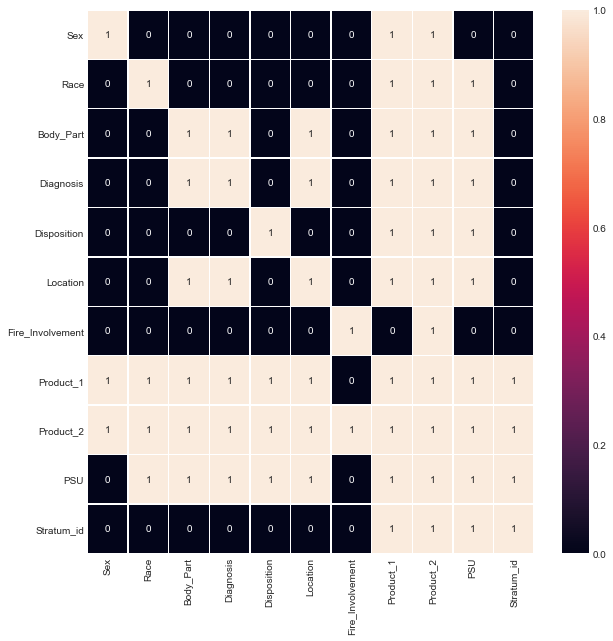

In [10]:
# contingency table
df = neiss_df.copy()
categorical = ['Sex', 'Race', 'Body_Part', 'Diagnosis', 'Disposition', 'Location',
               'Fire_Involvement', 'Product_1', 'Product_2', 'PSU', 'Stratum']
df = df.xs(categorical, axis=1)
df.dropna(inplace=True)
df['Race'] = [int(x) for x in df['Race']]
df = df[0:500]
UniqueId.addIdColumn(df, 'Stratum')
#df.rename(columns={'Stratum_id':'Stratum_code'}, inplace=True)
categorical[categorical.index('Stratum')] = 'Stratum_id'
df.drop('Stratum', inplace=True, axis='columns')
print(df)
print(categorical)

pcs1 = PearsonChiSquared(df)
dfCorrMatrix = pcs1.getCorrMatrixDataframe(categorical)
#print(dfCorrMatrix)

# Mask Upper triangle
# np.triu_indices_from(arr):  Return the indices for the upper-triangle of arr.
#mask = np.zeros_like(dfCorrMatrix)
#mask[np.triu_indices_from(mask)] = True
#mask

fig, ax = plt.subplots(figsize=(10, 10))

#sns.heatmap(dfCorrMatrix, annot=True, mask=mask, fmt="d", linewidths=0.4, ax=ax)
sns.heatmap(dfCorrMatrix, annot=True, linewidths=0.4, ax=ax)

# Fix the top and bottom margins of the heatmap
bottom_y, top_y = plt.ylim() 
bottom_y += 0.5 
top_y -= 0.5 
plt.ylim(bottom_y, top_y)

plt.show() 



In [11]:
# sns.pairplot(df)

In [25]:
def getHighCorrelations(df, dfCorrMatrix, minValue):
    high_correlations = []
    for y in dfCorrMatrix.index:
        for x in dfCorrMatrix.columns:
            if (x != y) and (dfCorrMatrix[y][x] > minValue):
                Y = y
                X = x
                if len(df[x]) > len(df[y]):
                    # Keep the smallest item on the X axis
                    Y = x
                    X = y

                high_correlations.insert(-1, (Y, X))
    high_correlations.sort()
    return high_correlations

high_correlations = getHighCorrelations(df, dfCorrMatrix, 0.95)
print(high_correlations)

None


In [ ]:
from IPython.display import display
button = widgets.Button(description="Click Me!")
output = widgets.Output()

#print(high_correlations.values)
select = high_correlations.values[0]
#print(select)
lCorrelations = ['{}, {}'.format(y, x) for y, x in high_correlations.values]
correlationDropDownSel = widgets.Dropdown(
    options=lCorrelations,
    value=lCorrelations[0],
    description='correlations',
    disabled=False,
)

typeDropDownSel = widgets.Dropdown(
    options=['swarm', 'scatter'],
    value='swarm',
    description='plot_type',
    disabled=False,
)

wHBox = widgets.HBox([correlationDropDownSel, typeDropDownSel])
wVBox = widgets.VBox([wHBox, button, output])

display(wVBox)

def on_button_clicked(b):
    with output:
        sel = correlationDropDownSel.value
        (xSel, ySel) = [x.strip() for x in sel.split(',')]
        print('-{}-, -{}-'.format(ySel, xSel))
        correlations(df, xSel, ySel, typeDropDownSel.value)

button.on_click(on_button_clicked)

In [ ]:
from IPython.display import display
button = widgets.Button(description="Click Me!")
output = widgets.Output()

xDropDownSel1 = widgets.Dropdown(
    options=categorical,
    value=categorical[0],
    description='xCategory',
    disabled=False,
)

yDropDownSel2 = widgets.Dropdown(
    options=categorical,
    value=categorical[1],
    description='yCategory',
    disabled=False,
)

typeDropDownSel3 = widgets.Dropdown(
    options=['swarm', 'scatter'],
    value='swarm',
    description='plot_type',
    disabled=False,
)

wHBox = widgets.HBox([xDropDownSel1, yDropDownSel2, typeDropDownSel3])
wVBox = widgets.VBox([wHBox, button, output])

display(wVBox)

def on_button_clicked(b):
    with output:
        correlations(df, xDropDownSel1.value, yDropDownSel2.value, typeDropDownSel3.value)

button.on_click(on_button_clicked)